### Performing the Girvan - Newman Algorithm using Spark, Graphframes and NetworkX

In [1]:
# Loading all the libraries required
from graphframes import *
import networkx as nx
from pyspark import *
from pyspark.sql import *
import matplotlib.pyplot as plt
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/home/training/miniconda3/envs/pyspark_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:

# Initializing spark session
spark = SparkSession.builder.appName('fun').getOrCreate()

# Creating a demo dataframe with Vertex and Edge Data 
vertices = spark.createDataFrame([
                                  ("a", "Alice", 34),
                                  ("b", "Bob", 36),
                                  ("c", "Charlie", 30),
                                  ("d", "David", 29),
                                  ("e", "Esther", 32),
                                  ("f", "Fanny", 36),
                                  ("g", "Gabby", 60),
                                  ("h", "Mark", 61),
                                  ("i", "Gunter", 62),
                                  ("j", "Marit", 63)], 
                                  ["id", "name", "age"])

edges = spark.createDataFrame([
                              ("a", "b", "friend"),
                              ("a", "e", "follow"),
                              ("c", "a", "follow"),
                              ("c", "f", "follow"),
                              ("g", "h", "follow"),
                              ("h", "i", "friend"),
                              ("h", "j", "friend"),
                              ("j", "h", "friend"),
                              ("e", "f", "friend"),
                              ("f", "h", "follow")], 
                              ["src", "dst", "relationship"])

# Creating the Graph
g = GraphFrame(vertices, edges)

#Viewing the edges and the vertices
print("Vertices : ")
g.vertices.show()
print("Edges : ")
g.edges.show()

## Check the number of edges of each vertex
g.degrees.show()

Vertices : 
+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
|  g|  Gabby| 60|
|  h|   Mark| 61|
|  i| Gunter| 62|
|  j|  Marit| 63|
+---+-------+---+

Edges : 
+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  a|  e|      follow|
|  c|  a|      follow|
|  c|  f|      follow|
|  g|  h|      follow|
|  h|  i|      friend|
|  h|  j|      friend|
|  j|  h|      friend|
|  e|  f|      friend|
|  f|  h|      follow|
+---+---+------------+

+---+------+
| id|degree|
+---+------+
|  g|     1|
|  f|     3|
|  e|     2|
|  h|     5|
|  c|     2|
|  i|     1|
|  j|     2|
|  b|     1|
|  a|     3|
+---+------+



In [3]:
# Function to visualize the graph

def PlotGraph(edge_list, colors = ["red","green","blue","yellow","orange","pink","grey","cyan","magenta","white"]):
    Gplot = nx.Graph()
    for row in edge_list.select("src","dst").take(50):
        Gplot.add_edge(row["src"],row["dst"])
    
    pos = nx.spring_layout(Gplot)
    plt.figure(figsize=(12,8))
    plt.subplot(121)
    nx.draw(Gplot, with_labels = True, node_size = 1000, width = 0.3, node_color = colors, pos= pos, font_size = 20)

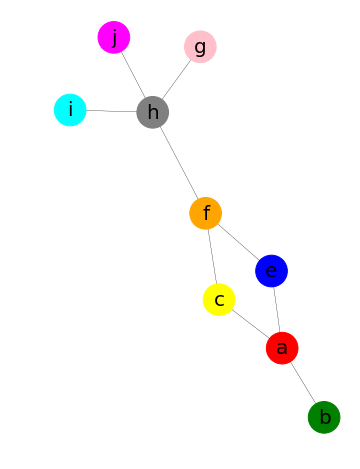

In [4]:
PlotGraph(g.edges)

In [5]:
# Helper functions

def convert_to_graphX(graph):
    Gplot = nx.Graph()
    for row in graph.edges.select("src","dst").take(50):
        Gplot.add_edge(row["src"],row["dst"])
    
    return Gplot

# Determining removing the edge
def edge_to_remove(graph):
    G_dict = nx.edge_betweenness_centrality(graph)
    edge = ()

    # extract the edge with highest edge betweenness centrality score
    for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
        edge = key
        break

    return edge

def girvan_newman(graph):
    graph = convert_to_graphX(graph)
    sg = nx.connected_components(graph)
    sg_count = nx.number_connected_components(graph)

    while(sg_count == 1):
        graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
        sg = nx.connected_components(graph)
        sg_count = nx.number_connected_components(graph)

    return sg
                       

In [6]:
c = girvan_newman(g)

In [7]:
k = 1
comm = []
for i in c:
    print("Community #{}".format(k))
    print(i)
    comm.append(list(sorted(i)))
    k+=1

Community #1
{'b', 'a', 'c', 'f', 'e'}
Community #2
{'g', 'i', 'j', 'h'}


In [8]:
# Plotting communities

def plot_communities(graph,comm):    
    graph = convert_to_graphX(g)
    color_map = []
    for node in graph:
        if node in comm[0]:
            color_map.append("red")
        else:
            color_map.append("cyan")
    pos = nx.spring_layout(graph)
    nx.draw(graph, with_labels = True, node_size = 1000, width = 0.3, node_color = color_map, 
            pos= pos, font_size = 20)
    plt.show()

Communities Plotted are: 


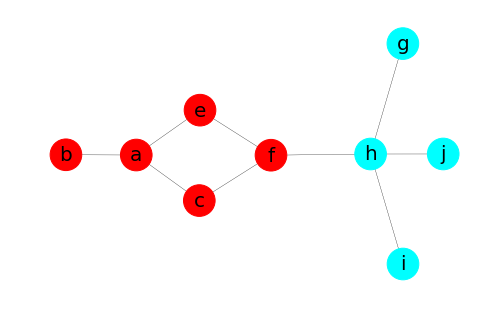

In [9]:
print("Communities Plotted are: ")
plot_communities(g,comm)